In [1]:
import datetime
print(datetime.datetime.now().isoformat())

2016-09-06T17:35:07.524377


# Is there a cutoff in Dst that allows slot filling?



## Method
Using a statistical model of the relationship between the slot filling at 464keV vs Dst. 

We model the number of slot filling events as a random sample from a binomial distribution meaning that there is a probability of the event occuring and there may be a parameter that changes the probability. This is not meant as a correlation but as a success failure creiteria. 

From Wikipedia:
In probability theory and statistics, the binomial distribution with parameters n and p is the discrete probability distribution of the number of successes in a sequence of n independent yes/no experiments, each of which yields success with probability p.





$
change \sim Bin(n,p) \\
logit(p) = \alpha + \beta x \\
a \sim N(0,5) \\
\beta \sim N(0,10)
$


where we set vague priors for $\alpha$ and $\beta$, the parameters for the logistic model.

This is the same technique used in the estimation of deaths due to a concentration of a chemical.

In [2]:
# http://onlinelibrary.wiley.com/doi/10.1002/2016JA022652/epdf


import pymc
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import spacepy.plot as spp

This unreleased version of SpacePy is not supported by the SpacePy team.


/Users/balarsen/miniconda3/envs/python3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Data delivered by Geoff Reeves 9/6/2016

In [3]:
# min_Dst, min_L
data = np.asarray([
65.000, 3.8000,  
50.000, 3.7000,
67.000, 3.5000,
61.000, 3.4000, 
77.000, 3.2000,
99.000, 2.8900,  
87.000, 2.8000,  
98.000, 2.8000, 
96.000, 2.8000,
93.000, 2.3000,
92.000, 2.3000, 
225.00, 2.3000, 
206.00, 2.3000,
125.00, 2.3000]).reshape((-1,2))

dst = data[:,0]
minL = data[:,1]
print(dst, minL, data.dtype)
                         
                         

[  65.   50.   67.   61.   77.   99.   87.   98.   96.   93.   92.  225.
  206.  125.] [ 3.8   3.7   3.5   3.4   3.2   2.89  2.8   2.8   2.8   2.3   2.3   2.3
  2.3   2.3 ] float64


In [4]:
# make bins in Dst
dst_bins = np.arange(25, 300, 10)
print(dst_bins)
dst_bins_centers = np.asarray([dst_bins[:-1] + np.diff(dst_bins)/2]).T[:,0]
print(dst_bins_centers, dst_bins_centers.shape)
n_events_dig = np.digitize(dst, dst_bins)
print(n_events_dig)
n_events = np.zeros(len(dst_bins)-1)
success = np.zeros_like(n_events)
for i, v in enumerate(np.unique(n_events_dig)):
    n_events[v-1] = np.sum(n_events_dig==v)
    success[v-1] = np.sum(minL[n_events_dig==v] <= 2.4)
print(n_events)
print(success)

[ 25  35  45  55  65  75  85  95 105 115 125 135 145 155 165 175 185 195
 205 215 225 235 245 255 265 275 285 295]
[  30.   40.   50.   60.   70.   80.   90.  100.  110.  120.  130.  140.
  150.  160.  170.  180.  190.  200.  210.  220.  230.  240.  250.  260.
  270.  280.  290.] (27,)
[ 5  3  5  4  6  8  7  8  8  7  7 21 19 11]
[ 0.  0.  1.  1.  2.  1.  3.  3.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  1.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  1.  0.  0.  0.  0.  0.  0.]


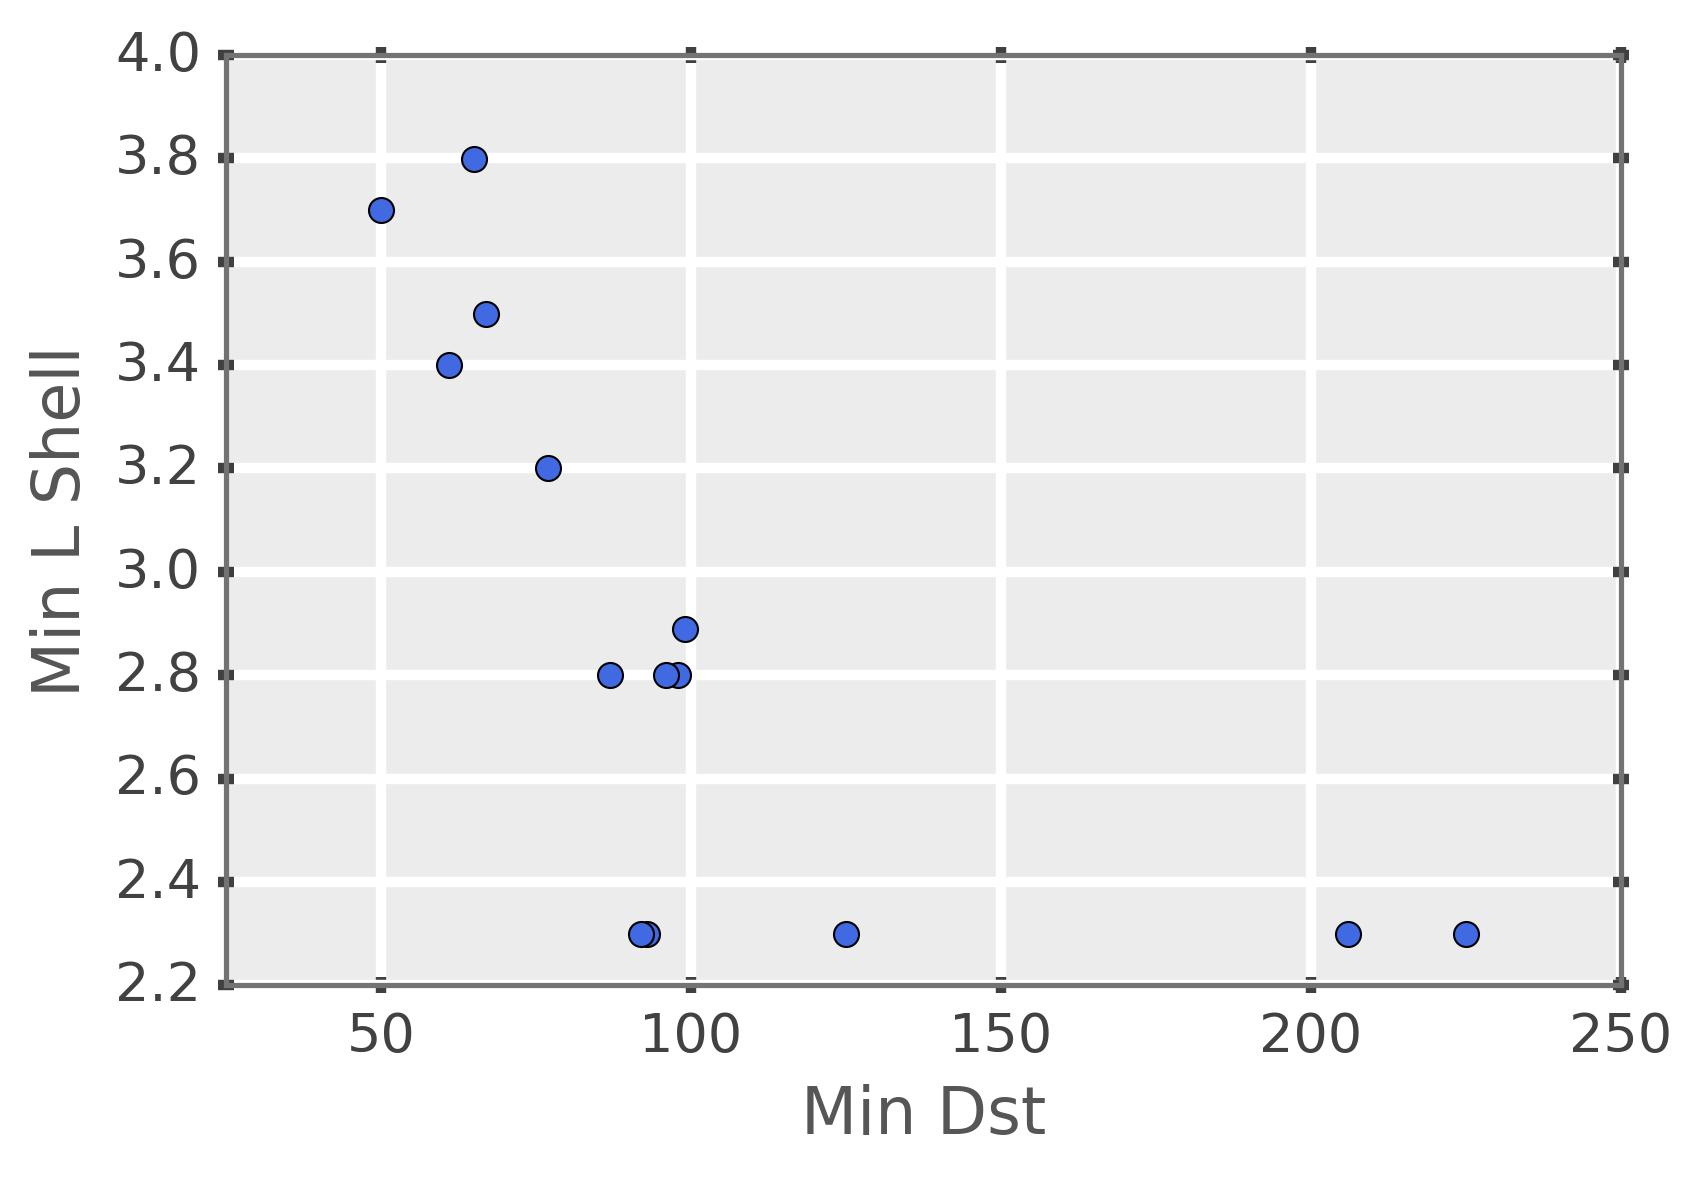

In [5]:
plt.plot(dst, minL, 'o')
plt.xlim((25, 250))
plt.ylim((2.2, 4.0))
plt.xlabel('Min Dst')
plt.ylabel('Min L Shell')

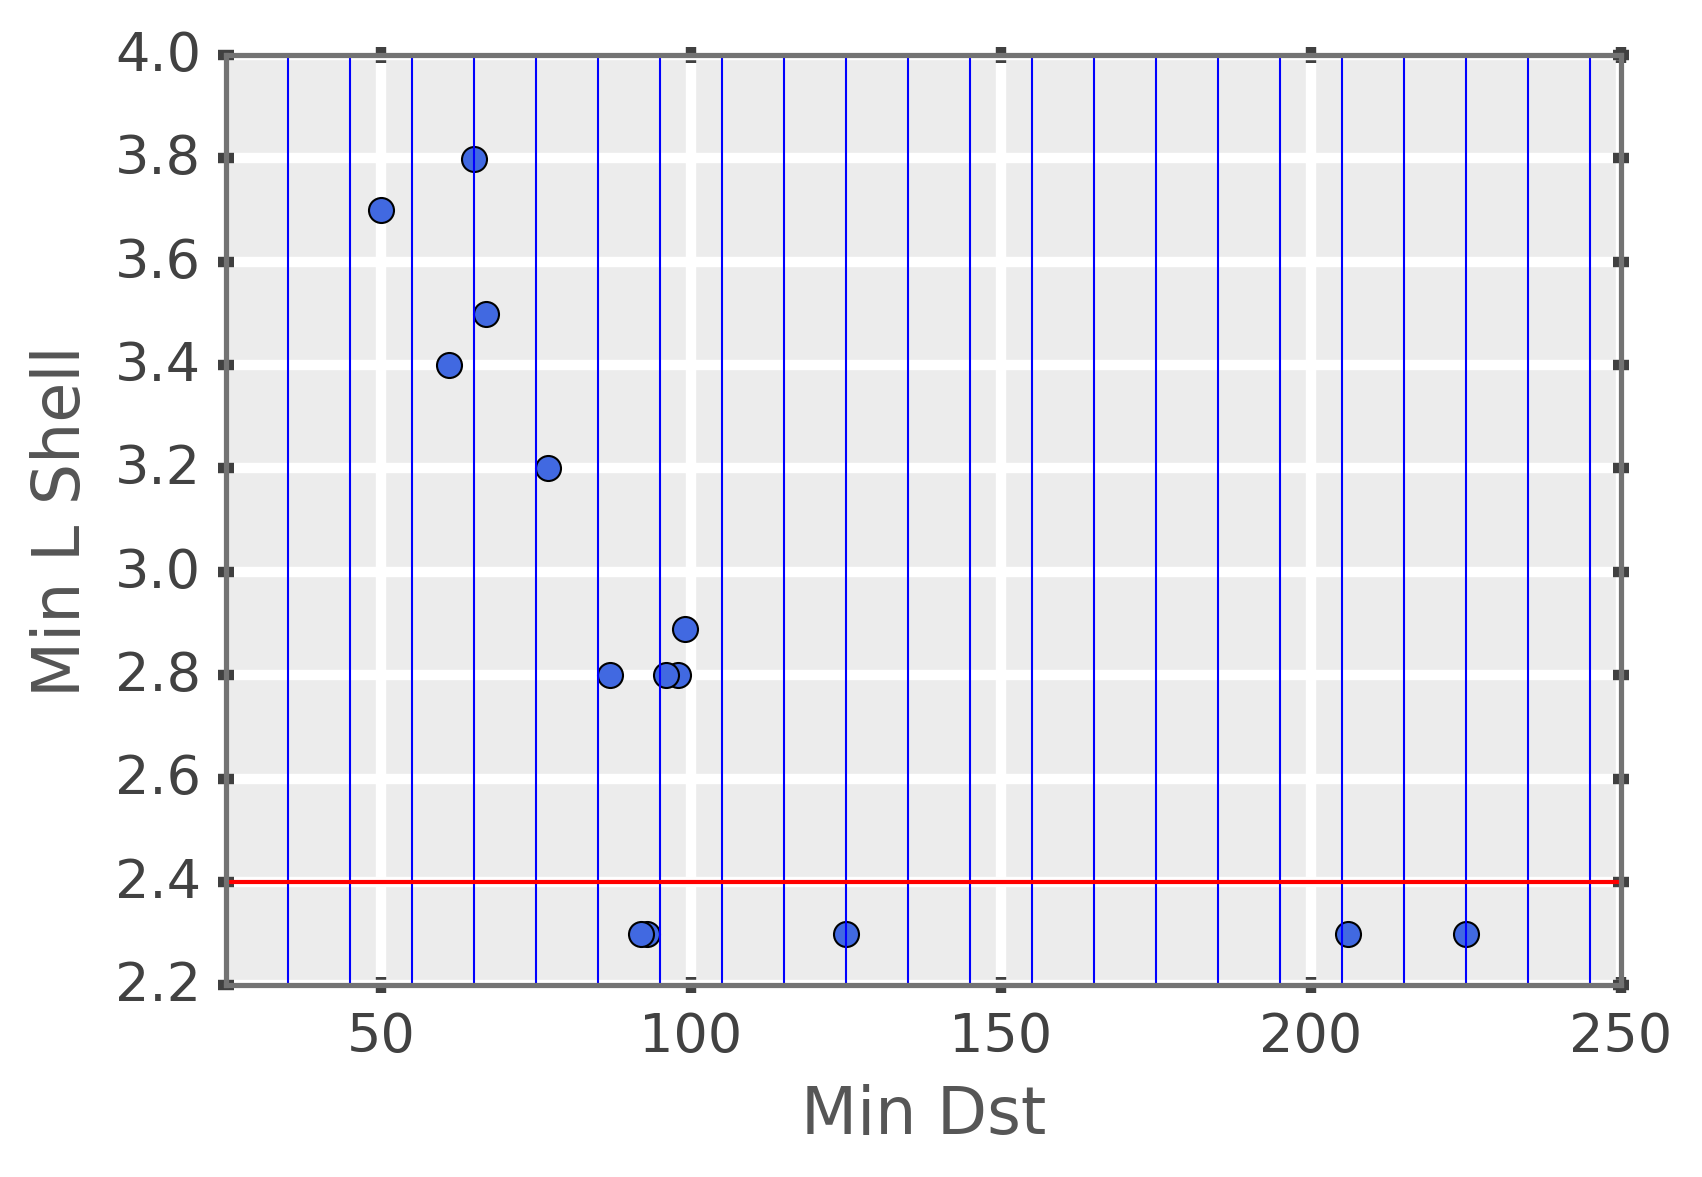

In [6]:
plt.plot(dst, minL, 'o')
plt.xlim((25, 250))
plt.ylim((2.2, 4.0))
plt.xlabel('Min Dst')
plt.ylabel('Min L Shell')
for v in dst_bins:
    plt.axvline(v, lw=0.5)
plt.axhline(2.4, c='r', lw=1)

## Oberved Data:
* n_pts : the number of points in each of the 25nT wide Dst bins
* successes : the number of events in each bin where the slot was filled (Min L = 2.3)
* dst_bins_centers : the centers of the Dst bins

In [7]:
# define invlogit function
def invlogit(x):
  return pymc.exp(x) / (1 + pymc.exp(x))

Setup the Bayesian model accorind to the description above. Run the Markov chain monte carlo (MCMC) to sample the posterior distributions for $\alpha$ and $\beta$

In [8]:
# define priors
# these are wide uninformative priors
# alpha = pymc.Normal('alpha', mu=0, tau=1.0/5**2)
# beta = pymc.Normal('beta', mu=0, tau=1.0/10**2)
alpha = pymc.Uniform('alpha', -500, 100, value = 1e-2)
beta = pymc.Uniform('beta', -100, 100, value = 1e-2)


# cannot feed in zero events
ind = n_events > 0
print(n_events.shape, dst_bins_centers.shape, success.shape, )

# define likelihood
p = pymc.InvLogit('p', alpha + beta*dst_bins_centers[ind])
print('n_events', n_events[ind], 'p', p.value, 'success', success[ind], )
y = pymc.Binomial('y_obs', n=n_events[ind], p=p, value=success[ind], observed=True)



(27,) (27,) (27,)
n_events [ 1.  1.  2.  1.  3.  3.  1.  1.  1.] p [ 0.62480647  0.6479408   0.67040116  0.6921095   0.71300016  0.73302015
  0.78751316  0.89187133  0.90970186] success [ 0.  0.  0.  0.  2.  0.  1.  1.  1.]


In [9]:
# inference
m = pymc.Model([alpha, beta, y])
mc = pymc.MCMC(m)
mc.sample(iter=500000, burn=1000, burn_till_tuned=True, thin=300)

 [-----------------103%------------------] 520117 of 504000 complete in 59.5 sec

Make diagnostic plots of the posteriour distributions as created using MCMC.  

Plotting beta
Plotting alpha


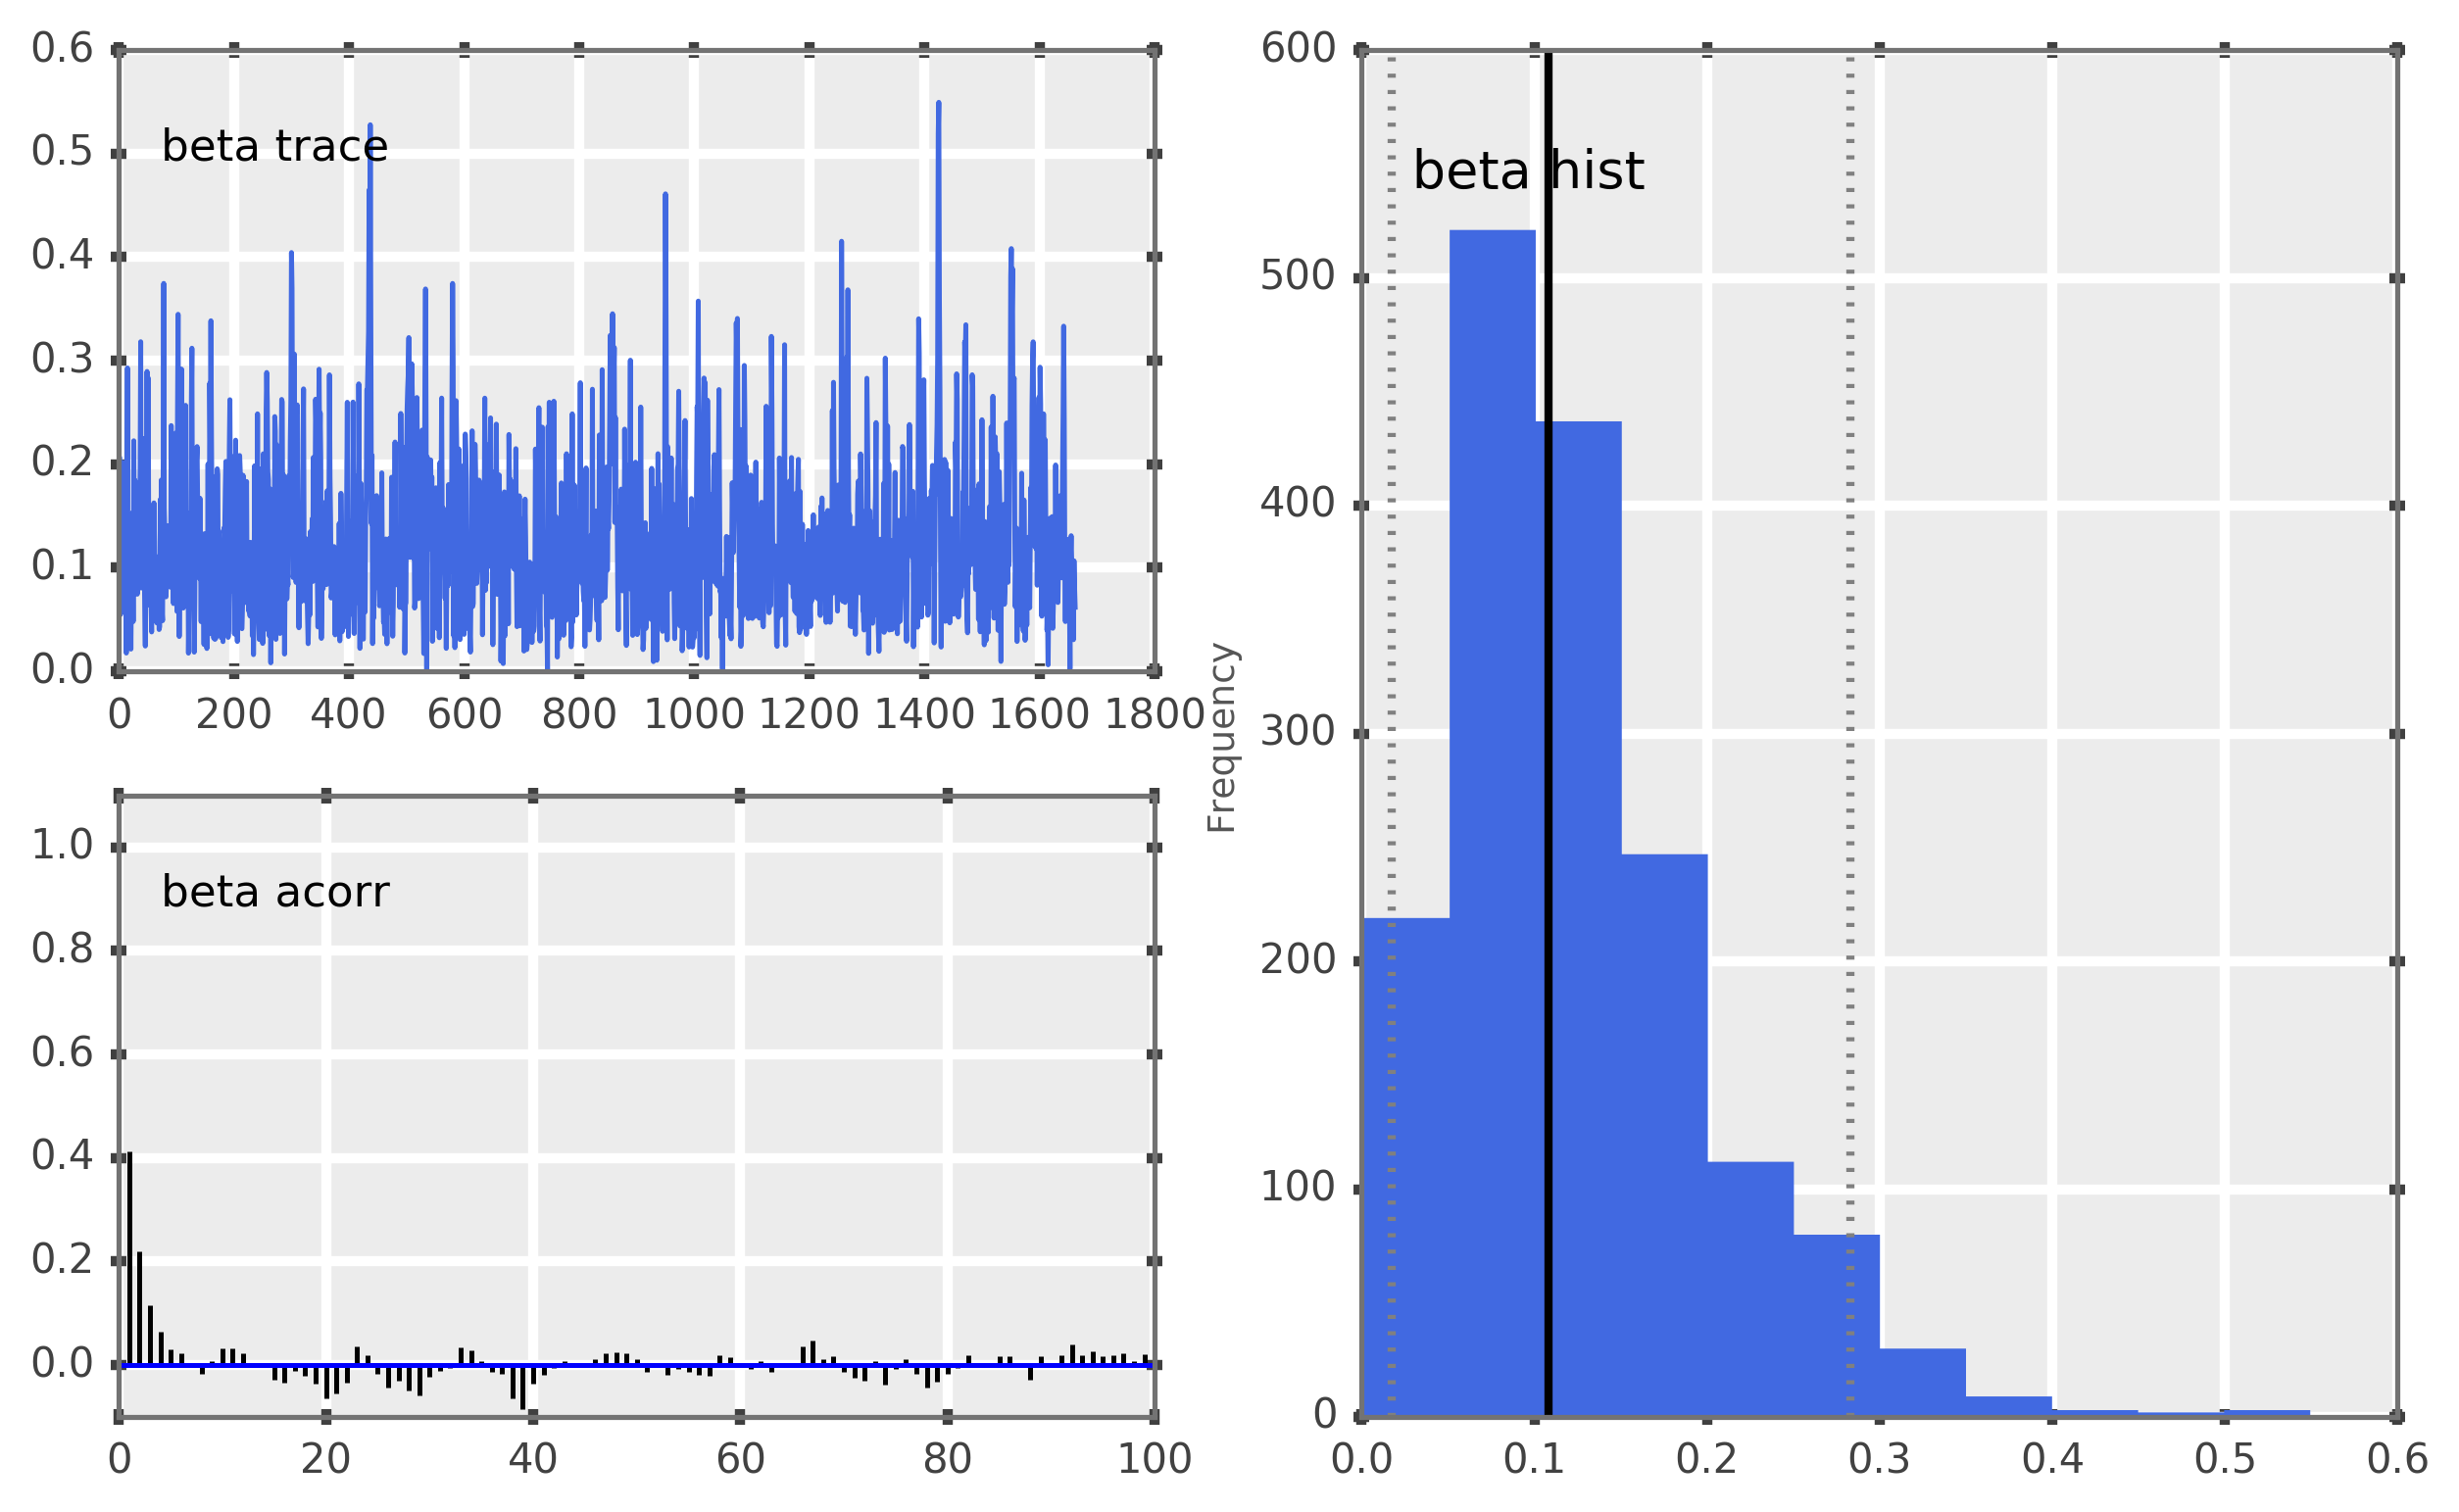

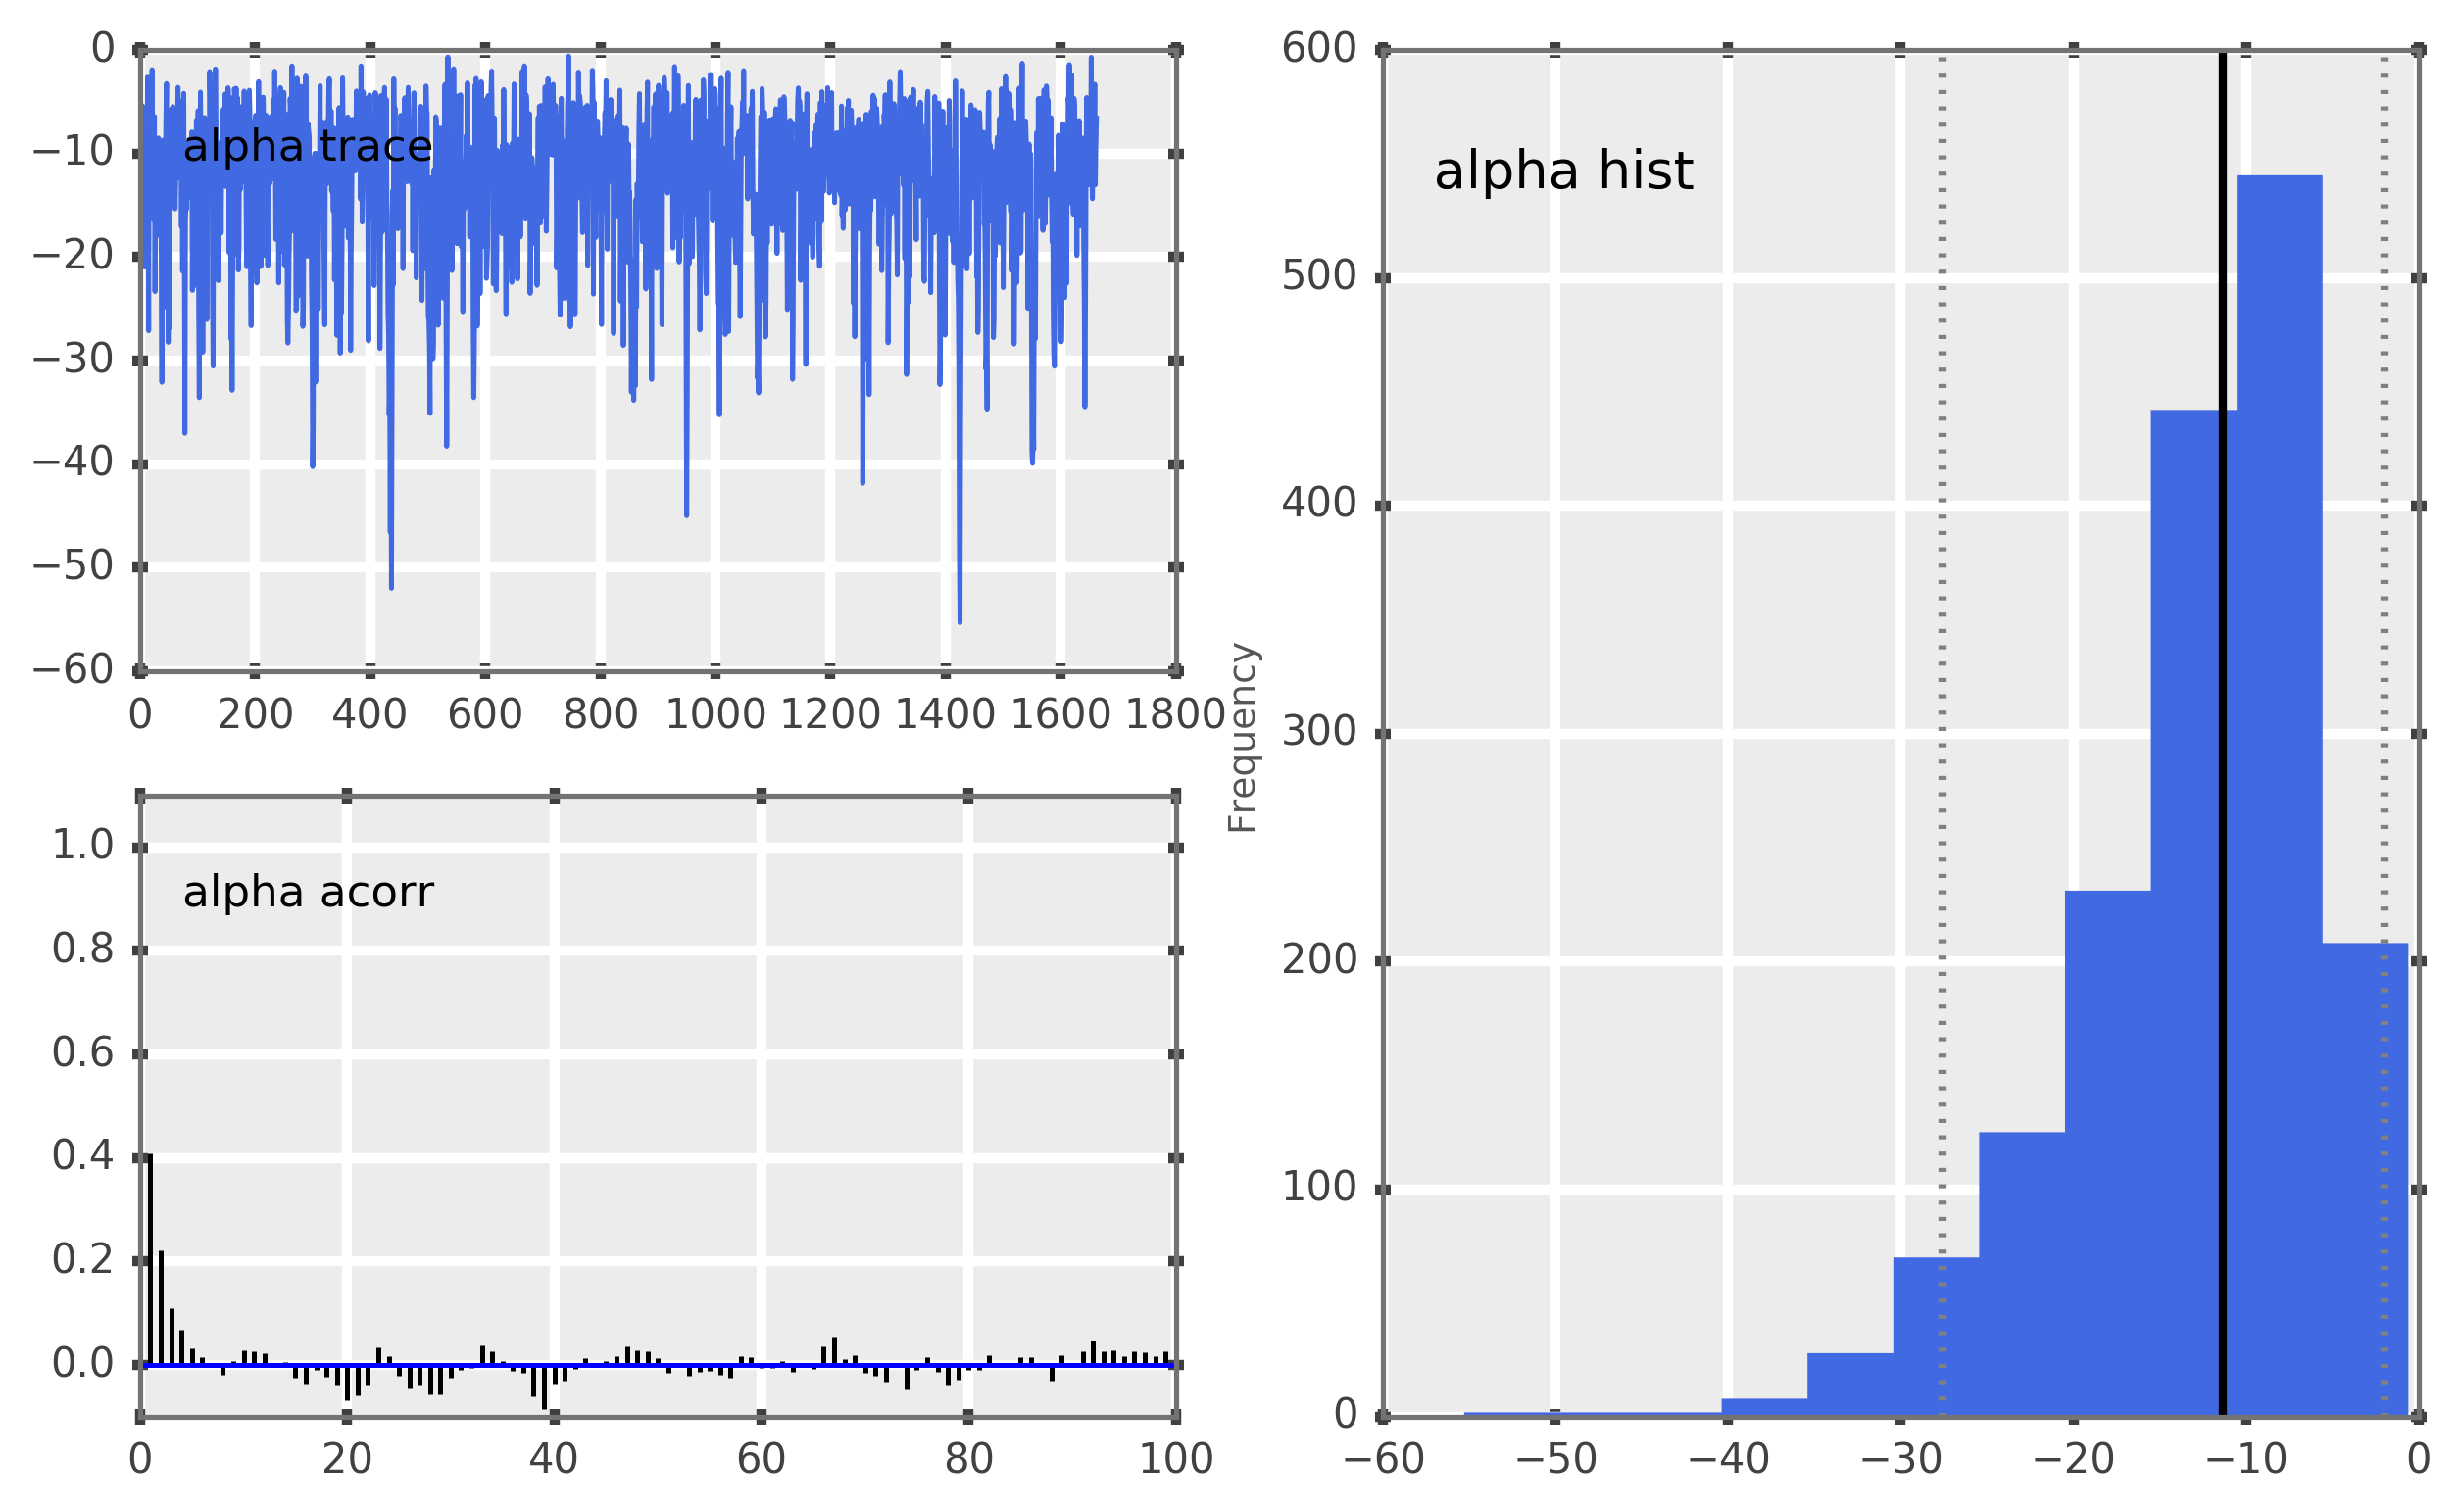

In [10]:
pymc.Matplot.plot(mc)

In [11]:
pprint(mc.stats())

{'alpha': {'95% HPD interval': array([-27.56143888,  -1.96480291]),
           'mc error': 0.27710545888311766,
           'mean': -12.867477846768763,
           'n': 1663,
           'quantiles': {2.5: -30.529326429640818,
                         25: -16.510387635459143,
                         50: -11.340424792268269,
                         75: -7.6931778413526004,
                         97.5: -3.1012134895051413},
           'standard deviation': 7.2555594448199887},
 'beta': {'95% HPD interval': array([ 0.01733102,  0.28330841]),
          'mc error': 0.0028476299547380733,
          'mean': 0.12526963866884139,
          'n': 1663,
          'quantiles': {2.5: 0.024432704933464756,
                        25: 0.071512434362979604,
                        50: 0.10837410740623696,
                        75: 0.16372552966125442,
                        97.5: 0.3034408483142198},
          'standard deviation': 0.075247231459840552}}


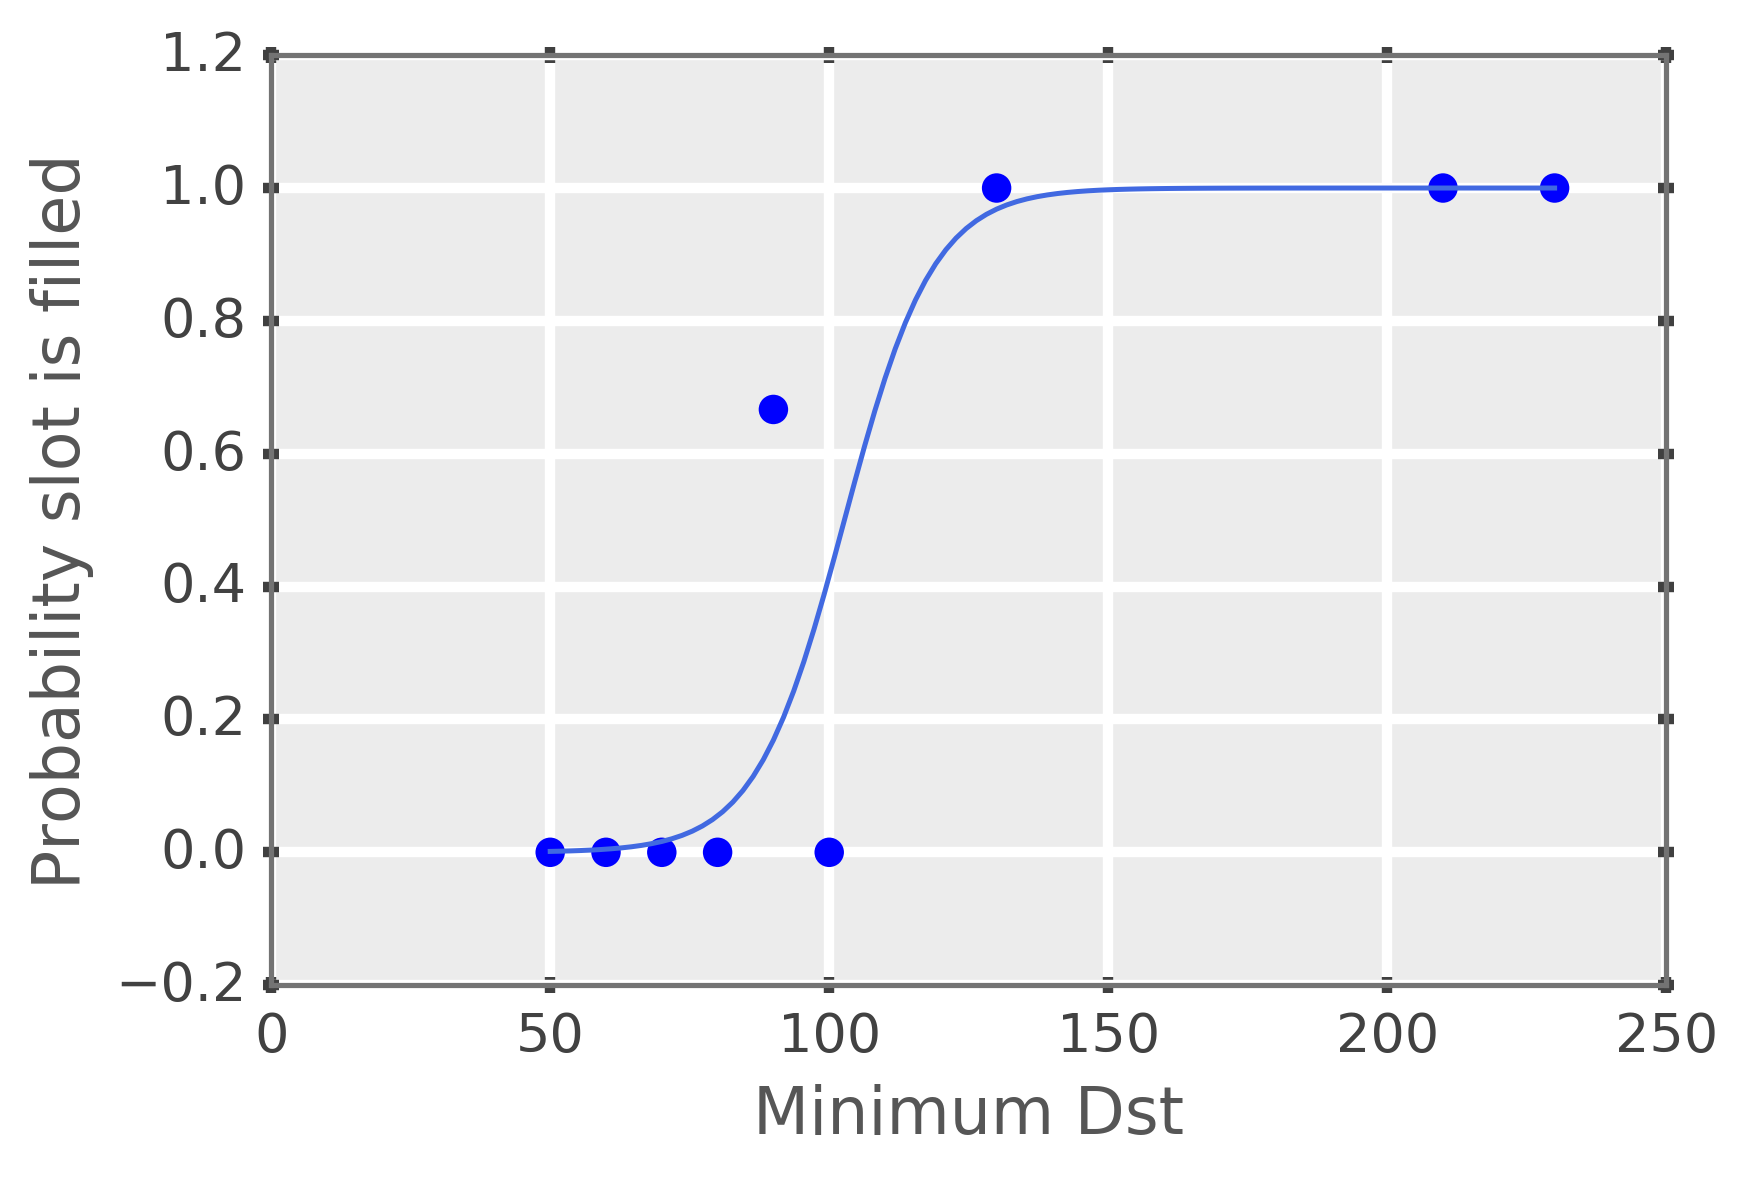

In [12]:
xp = np.linspace(dst_bins_centers[ind].min(), dst_bins_centers[ind].max(), 100)
a = alpha.stats()['mean']
b = beta.stats()['mean']
y_val = invlogit(a + b*xp).value
plt.plot(xp, y_val)
plt.scatter(dst_bins_centers[ind], success[ind]/n_events[ind], s=50);
plt.xlabel('Minimum Dst')
plt.ylabel('Probability slot is filled')
plt.gca().ticklabel_format(useOffset=False)


## Predictions based on this model

In [13]:
# get the minimum Dst where 99% should be successes
ind99 = y_val >= 0.99
minDst99 = xp[ind99][0]
print('At a minimum Dst of {0:0.0f}nT it is predicted to have a 99% percent of a slot filling'.format(minDst99))

At a minimum Dst of 141nT it is predicted to have a 99% percent of a slot filling


## Plot up many lines for a feel at uncertantity

In [14]:
# one should be able to get estimates of the line uncertainity
ilu = np.empty((1000, len(xp)), dtype=float)
for ii, v in enumerate(np.random.random_integers(0, len(alpha.trace[:])-1, 1000)):
  ilu[ii] = invlogit(alpha.trace[:][v] + beta.trace[:][v]*xp).value


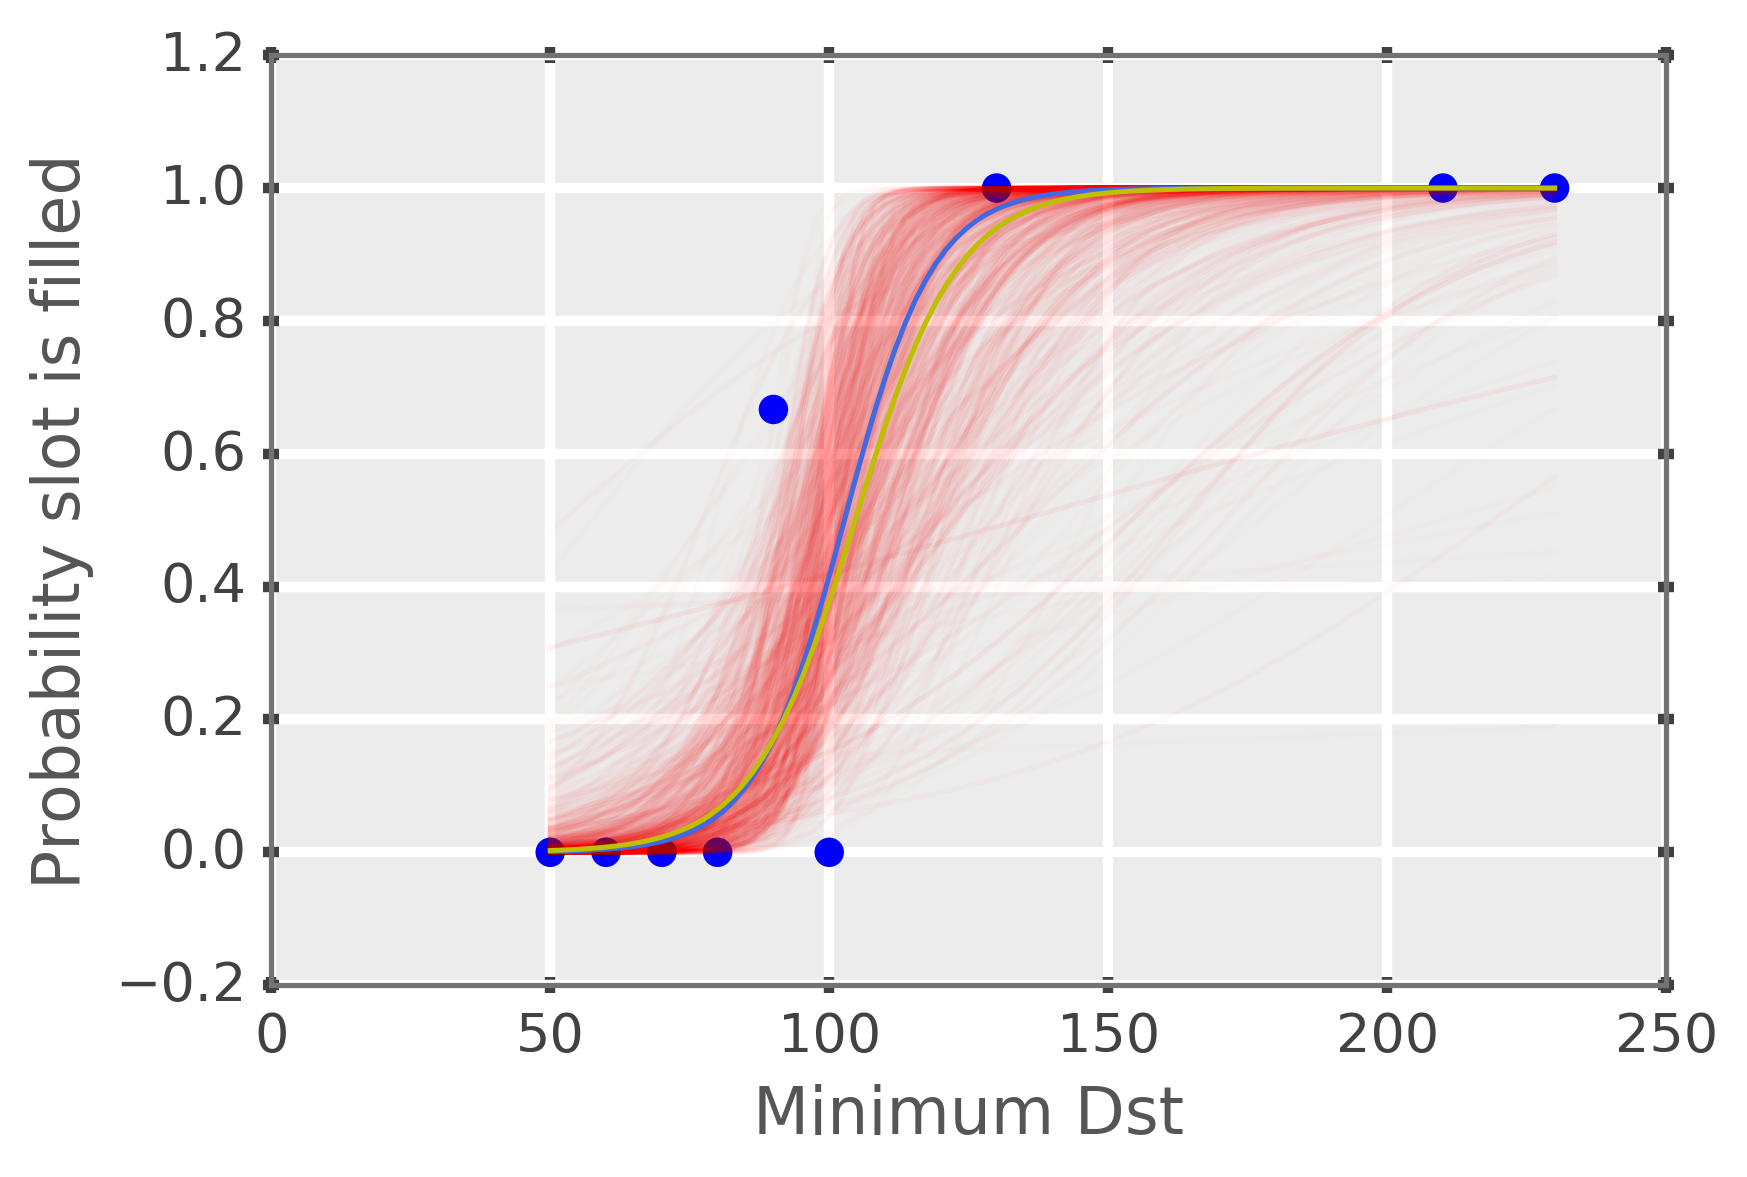

In [15]:
xp = np.linspace(dst_bins_centers[ind].min(), dst_bins_centers[ind].max(), 100)
for v in ilu:
  plt.plot(xp, v, alpha=.01, c='r')


a = alpha.stats()['mean']
b = beta.stats()['mean']
plt.plot(xp, invlogit(a + b*xp).value)

a = alpha.stats()['quantiles'][50]
b = beta.stats()['quantiles'][50]
plt.plot(xp, invlogit(a + b*xp).value, c='y')


plt.scatter(dst_bins_centers[ind], success[ind]/n_events[ind], s=50);
plt.xlabel('Minimum Dst')
plt.ylabel('Probability slot is filled')

Same as previous figure with the red lines overlayed as 100 joint draws from the model posterior in order to show spread. 